### Dataset: Diabetes prediction dataset
- Se utilizará el dataset disponible desde la url:
  - https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
- La descarga se realizará mediante el api de Kagggle, para ello se instaló el paquete correspondiente.

### >>Mis conclusiones y resumen se encuentran en la última celda<<

### Importanción de módulos y descarga de dataset desde kaggle

In [1]:
import os

import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import binarize
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import zipfile

#### La descarga de los datasets fueron a través de la API de Kaggle, la siguiente celda no funcionará a menos que descargue las credenciales de API  y se deje disponible el archivo kaggle.json dentro de la carpeta .kaggle en la carpeta home del usuario. 


##### Se omite mis credenciales por temas de seguridad). Sin embargo, al hacer inicio de sesión en Kaggle se puede abrir la sección de configuración donde se encontrará la sección de API "https://www.kaggle.com/settings".


##### Para facilitar la corrección del trabajo, se adjunta los archivos CSV dentro de la carpeta 'source' dentro del mismo zip enviado. 

#### Para ejecutar la siguiente celda, el entorno virtual debe tener kaggle==1.6.6 (está incluido dentro del archivo Pipfile y Pipfile.lock)

In [2]:
try:
    !kaggle datasets download -d iammustafatz/diabetes-prediction-dataset -p source/
    zipfile.ZipFile(os.path.join('source','diabetes-prediction-dataset.zip')).extractall('source')
except:
    print('\033[91m' + 'Elimine los archivos de la carpeta "source" e intente de nuevo, ocurrió un problema al encontrar archivos existentes.' + '\033[0m')


  0%|          | 0.00/734k [00:00<?, ?B/s]
100%|##########| 734k/734k [00:00<00:00, 1.31MB/s]
100%|##########| 734k/734k [00:00<00:00, 1.31MB/s]


### Estableciendo la ruta del archivo y variables generales

In [3]:
diabetes_prediction_dataset = os.path.join('source','diabetes_prediction_dataset.csv')

### Cargando archivo a Pandas DataFrame

In [4]:
df = pd.read_csv(diabetes_prediction_dataset, on_bad_lines='skip')

### Viendo una muestra, identificando tipos de campos y valores nulos

In [5]:
display(df.sample(3))
display(df.describe(include='all'))
df.info()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
22794,Female,66.0,1,0,No Info,33.83,5.7,80,0
89774,Female,49.0,0,0,never,23.26,6.1,200,0
39722,Female,36.0,0,0,No Info,37.38,6.6,80,0


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### Contando y eliminando duplicados

In [6]:
print(f'El dataset tiene {df.shape[0]} registros y contiene un total de {df.duplicated().sum()} valores duplicados')
df.drop_duplicates(inplace=True)
print(f'El dataset ahora tiene {df.shape[0]} registros y contiene un total de {df.duplicated().sum()} valores duplicados')

El dataset tiene 100000 registros y contiene un total de 3854 valores duplicados
El dataset ahora tiene 96146 registros y contiene un total de 0 valores duplicados


### Codificando columnas de tipo cadena y mostrando el diccionario de valores, de ser requerido se pueden guardar en el disco local como archivos pickle: https://docs.python.org/3/library/pickle.html

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['gender_enc']= le.fit_transform(df['gender'])
print(f'El diccionario generado como resultado de la codificación de los valores de la columna Gender es: ')
display(df.groupby('gender',as_index=False)['gender_enc'].apply(lambda s: s.sample(1)))

df['smoking_history_enc']= le.fit_transform(df['smoking_history'])
print(f'El diccionario generado como resultado de la codificación de los valores de la columna Smoking es: ')
display(df.groupby('smoking_history',as_index=False)['smoking_history_enc'].apply(lambda s: s.sample(1)))

df.drop(['gender','smoking_history'], axis=1, inplace=True)

El diccionario generado como resultado de la codificación de los valores de la columna Gender es: 


,gender,gender_enc
0,Female,0
1,Male,1
2,Other,2


El diccionario generado como resultado de la codificación de los valores de la columna Smoking es: 


,smoking_history,smoking_history_enc
0,No Info,0
1,current,1
2,ever,2
3,former,3
4,never,4
5,not current,5


Existe una relación de por cada 100 muestras 9 de ellas son positivas


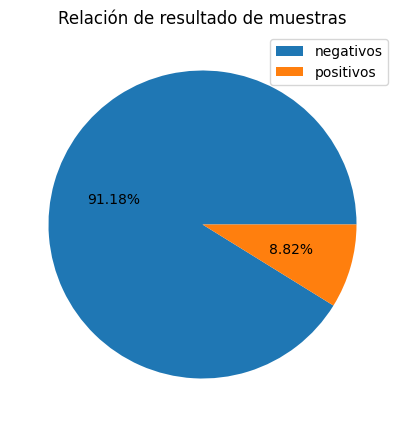

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
plt.pie(df['diabetes'].value_counts(), autopct='%.2f%%')
plt.title('Relación de resultado de muestras')
ax.legend(labels=['negativos', 'positivos'])
print('Existe una relación de por cada 100 muestras 9 de ellas son positivas')
plt.show()

En base al análisis de correlación, se puede identificar que la edad y el bmi son los valores más ligados
Sin embargo, la relación de estos valores solo mantiene un indicador de 0.34 
Sería ideal encontrar un indicador de relación mayor a 0.8 para presumir algo más fundamentado.


<Axes: >

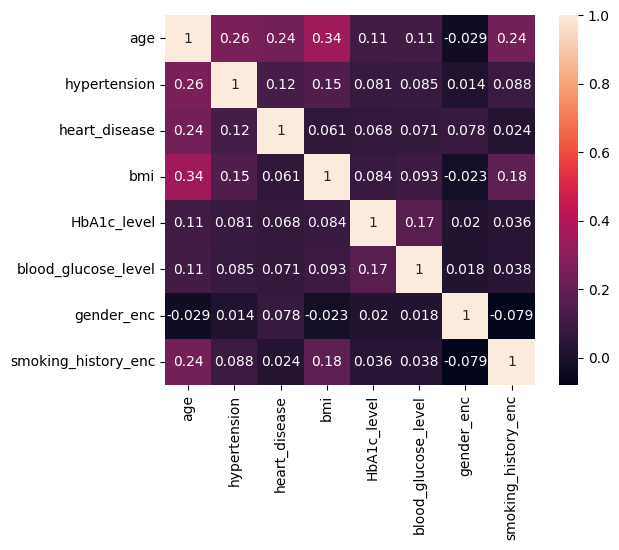

In [9]:
print('En base al análisis de correlación, se puede identificar que la edad y el bmi son los valores más ligados')
print('Sin embargo, la relación de estos valores solo mantiene un indicador de 0.34 \nSería ideal encontrar un indicador de relación mayor a 0.8 para presumir algo más fundamentado.')
sns.heatmap(df.loc[:, df.columns != 'diabetes'].corr(), square=True, annot=True)

### Partiendo datos y separando los datos que serán para validación (out of sample)

In [10]:
X = df.loc[:, df.columns != 'diabetes']
y = df.diabetes

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42, stratify=y)

### KNN

#### Se realiza la definición de las variables a evaluar mediante gridsearch cross validation. He optado gridsearch en lugar de randomized grid search porque quería tener una visión mas ámplia y los recursos de cómputo me lo permiten

In [10]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

#### Se trabaja con un cross validation de 10 y teniendo como referecia el accuracy a obtener

In [11]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

#### Una función de apoyo para el gráfico de los resultados del accuracy mediante el gridsearch

In [12]:
def plot_comparison():
    x_data = np.arange(30)
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(x_data,knn_results_gr['distance'],'go:',label='Distance weight',linewidth=1)
    ax.plot(x_data,knn_results_gr['uniform'],'ro:',label='Uniform weight',linewidth=1)
    ax.set_xticks(x_data)
    ax.set_xticklabels(x_data)
    ax.legend(loc='best') 
    ax.set_xlim([0,29])
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    ax.set_ylabel("Cross-Validated Accuracy")
    ax.set_xlabel("Value of K for KNN")
    plt.grid()
    plt.show()

#### Visualización gráfica y de tabla de los resultados. También, se muestra los hiperparámetros más óptimos.

El mejor score de accuracy encontrado es de 0.9512455059377775
Los hiperparámetros más adecuados para este clasificador "KNN" son: {'n_neighbors': 7, 'weights': 'uniform'}


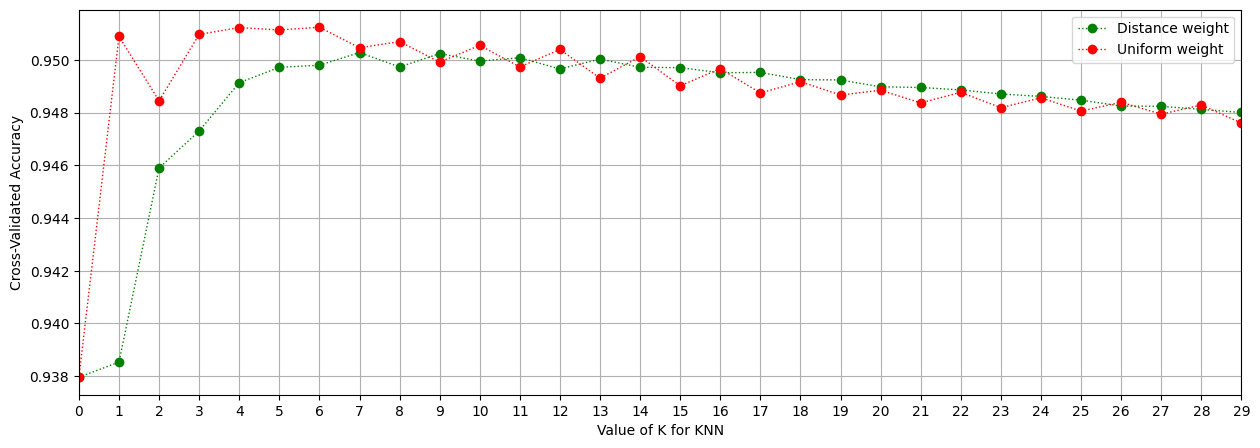

,distance,uniform
0,0.937958,0.937958
1,0.938530,0.950894
2,0.945902,0.948450
3,0.947306,0.950972
4,0.949139,0.951232
5,0.949724,0.951141
6,0.949802,0.951246
7,0.950283,0.950465
8,0.949737,0.950699
9,0.950244,0.949919


In [13]:
knn_results = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]
mask_distance = knn_results.index.isin(list(range(1,60,2)))
mask_uniform = knn_results.index.isin(list(range(0,60,2)))
my_dict = {
    'distance': list(knn_results[mask_distance]['mean_test_score']),
    'uniform': list(knn_results[mask_uniform]['mean_test_score'])
}
knn_results_gr = pd.DataFrame(my_dict)
print(f'El mejor score de accuracy encontrado es de {grid.best_score_}')
print(f'Los hiperparámetros más adecuados para este clasificador "KNN" son: {grid.best_params_}')
plot_comparison()
display(knn_results_gr)

#### Se entrena el modelo con los hiperparámetros identificados y se realiza la medición de accuracy en base a los datos out of sampling

In [14]:
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform')
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(f'El accuracy encontrado con los datos out of sampling es {metrics.accuracy_score(y_test, y_pred_class)}')

El accuracy encontrado con los datos out of sampling es 0.9521580863234529


#### Se realiza el análisis mediante la matriz de confusión para encontrar la sensitividad correspondiente

In [15]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(f'La matriz de confusión es: \n {confusion}')
print(f'La sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_class)}')
print('Este valor es muy bajo por lo que será necesario ajustar el umbral por defecto de 0.5, pues en este escenario muchos enfermos no son detectados correctamente.')

La matriz de confusión es: 
 [[17439    95]
 [  825   871]]
La sensitividad obtenida es de 0.5135613207547169
Este valor es muy bajo por lo que será necesario ajustar el umbral por defecto de 0.5, pues en este escenario muchos enfermos no son detectados correctamente.


#### Visualización de probabilidad que cada muestra corresponda a un caso positivo de diabetes.

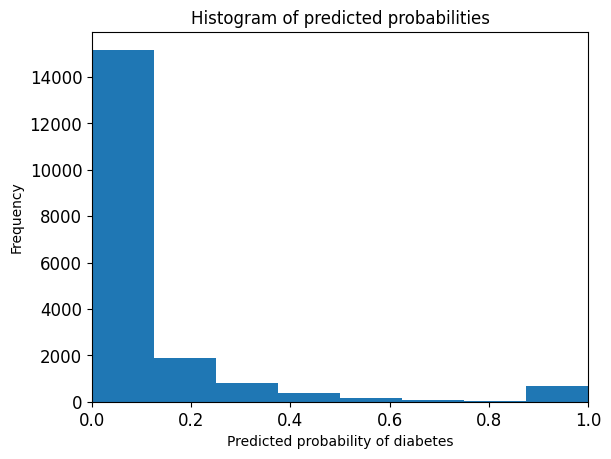

In [16]:
y_pred_prob = knn.predict_proba(X_test)[:,1]

fig, ax = plt.subplots()
ax.hist(y_pred_prob, bins=8)
ax.set_xlim(0, 1)
ax.set_title('Histogram of predicted probabilities')
ax.set_xlabel('Predicted probability of diabetes')
ax.set_ylabel('Frequency')
plt.show()

#### Cambiando el umbral para la clasificación de positivos de 0.5 a 0.1 para maximizar la sensitividad.

In [17]:
y_pred_class = binarize([y_pred_prob], threshold=0.1)[0]
confusion_class = metrics.confusion_matrix(y_test, y_pred_class)
print(f'La matriz de confusión con el umbral de 0.1 ahora es: \n {confusion_class}')
print(f'La nueva sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_class)}')
print('Este valor ahora es mejor en 34% aprox., si bien es cierto incrementamos los errores en la diagnosticación de los pacientes que no tienen diabetes, la necesidad de esta solución permite tener este tipo de equivocaciones para la detección de los negativos identificados como positivos')

La matriz de confusión con el umbral de 0.1 ahora es: 
 [[14938  2596]
 [  243  1453]]
La nueva sensitividad obtenida es de 0.8567216981132075
Este valor ahora es mejor en 34% aprox., si bien es cierto incrementamos los errores en la diagnosticación de los pacientes que no tienen diabetes, la necesidad de esta solución permite tener este tipo de equivocaciones para la detección de los negativos identificados como positivos


#### Se realizará la identificación de la sensitividad mediante la métrica ROC y el valor bajo su curva (AUC)

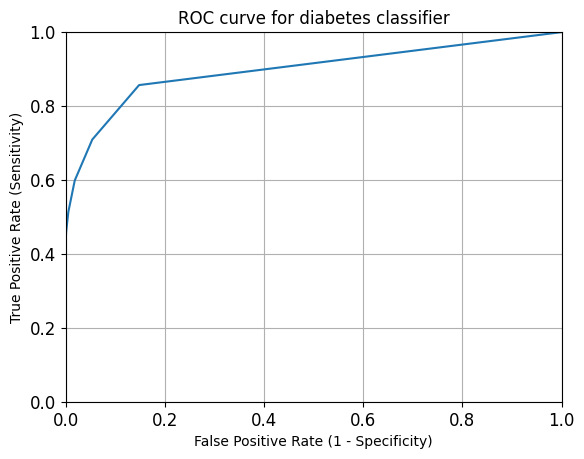

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title('ROC curve for diabetes classifier')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

#### Una función de apoyo para identificar la sensitividad de otra forma sin necesidad de cambiar los umbrales como en los pasos anteriores

In [19]:
def evaluate_threshold(threshold):
    print(f'La sensitividad para el threshold de {threshold} es', tpr[thresholds > threshold][-1])
evaluate_threshold(0.1)

La sensitividad para el threshold de 0.1 es 0.8567216981132075


#### El área bajo la curva, se espera que el valor obtenido sea mayor 0.7 para que sea aceptable

In [20]:
print(f'El valor del área bajo la curva con el umbral de clasificación de 0.5 es {metrics.roc_auc_score(y_test, y_pred_prob)}')
print(f'El valor del área bajo la curva con el umbral de clasificación de 0.1 es {metrics.roc_auc_score(y_test, y_pred_class)}')

El valor del área bajo la curva con el umbral de clasificación de 0.5 es 0.8977007575309212
El valor del área bajo la curva con el umbral de clasificación de 0.1 es 0.8543332455434294


### Regresión logística

#### Se realiza la definición de las variables a evaluar mediante randomizedsearch cross validation. He optado por randomizedsearch en lugar de gridsearch para acelerar las pruebas.

In [21]:
iter_range = list(range(95, 110))
solver_options = ['liblinear', 'saga']
penalty_options = ['l2', 'l1']
param_grid = dict(max_iter=iter_range, solver=solver_options, penalty=penalty_options)

#### Se trabaja con un cross validation de 10 y teniendo como referencia el accuracy a obtener

In [22]:
logreg = LogisticRegression()
rand = RandomizedSearchCV(logreg, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
rand.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'max_iter': [95, 96, 97, 98, 99, 100,
                                                     101, 102, 103, 104, 105,
                                                     106, 107, 108, 109],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='accuracy')

#### Identificación de hiperparámetros a utilizar según el mejor score de accuracy obtenido.

In [24]:
print(f'El mejor score de accuracy encontrado es de 0.958539 con la menor variación equivalente a 0.002165')
print(f'Los hiperparámetros más adecuados para este clasificador "Logistic Regression" son: "solver": "liblinear", "penalty": "l2", "max_iter": 106')
pd.set_option('display.max_colwidth', None)
display(pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

El mejor score de accuracy encontrado es de 0.958539 con la menor variación equivalente a 0.002165
Los hiperparámetros más adecuados para este clasificador "Logistic Regression" son: "solver": "liblinear", "penalty": "l2", "max_iter": 106


,mean_test_score,std_test_score,params
0,0.919796,0.001011,"{'solver': 'saga', 'penalty': 'l2', 'max_iter': 106}"
1,0.919705,0.000930,"{'solver': 'saga', 'penalty': 'l1', 'max_iter': 103}"
2,0.919445,0.000967,"{'solver': 'saga', 'penalty': 'l1', 'max_iter': 100}"
3,0.919068,0.000898,"{'solver': 'saga', 'penalty': 'l1', 'max_iter': 96}"
4,0.958539,0.002165,"{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 106}"
5,0.918977,0.000897,"{'solver': 'saga', 'penalty': 'l2', 'max_iter': 95}"
6,0.919302,0.000947,"{'solver': 'saga', 'penalty': 'l1', 'max_iter': 98}"
7,0.958656,0.002190,"{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 108}"
8,0.958682,0.002216,"{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 106}"
9,0.919835,0.001040,"{'solver': 'saga', 'penalty': 'l2', 'max_iter': 107}"


#### Se entrena el modelo con los hiperparámetros identificados y se realiza la medición de accuracy en base a los datos out of sampling

In [25]:
logreg = LogisticRegression(solver='liblinear', penalty='l2', max_iter=106)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
print(f'El accuracy encontrado con los datos out of sampling es {metrics.accuracy_score(y_test, y_pred_class)}')

El accuracy encontrado con los datos out of sampling es 0.9593863754550181


#### Se realiza el análisis mediante la matriz de confusión para encontrar la sensitividad correspondiente

In [27]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(f'La matriz de confusión es: \n {confusion}')
print(f'La sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_class)}')
print('Este valor es muy bajo por lo que será necesario ajustar el umbral por defecto de 0.5, pues en este escenario muchos enfermos no son detectados correctamente.')

La matriz de confusión es: 
 [[17385   149]
 [  632  1064]]
La sensitividad obtenida es de 0.6273584905660378
Este valor es muy bajo por lo que será necesario ajustar el umbral por defecto de 0.5, pues en este escenario muchos enfermos no son detectados correctamente.


#### Visualización de probabilidad que cada muestra corresponda a un caso positivo de diabetes.

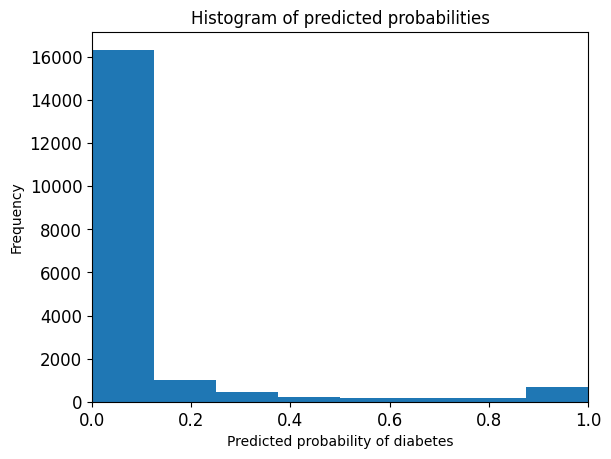

In [28]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fig, ax = plt.subplots()
ax.hist(y_pred_prob, bins=8)
ax.set_xlim(0, 1)
ax.set_title('Histogram of predicted probabilities')
ax.set_xlabel('Predicted probability of diabetes')
ax.set_ylabel('Frequency')
plt.show()

#### Cambiando el umbral para la clasificación de positivos de 0.5 a 0.1 para maximizar la sensitividad.

In [29]:
y_pred_class = binarize([y_pred_prob], threshold=0.1)[0]
confusion_class = metrics.confusion_matrix(y_test, y_pred_class)
print(f'La matriz de confusión con el umbral de 0.1 ahora es: \n {confusion_class}')
print(f'La nueva sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_class)}')
print('Este valor ahora es mejor en 24% aprox., si bien es cierto incrementamos los errores en la diagnosticación de los pacientes que no tienen diabetes, la necesidad de esta solución permite tener este tipo de equivocaciones para la detección de los negativos identificados como positivos')

La matriz de confusión con el umbral de 0.1 ahora es: 
 [[15671  1863]
 [  236  1460]]
La nueva sensitividad obtenida es de 0.8608490566037735
Este valor ahora es mejor en 24% aprox., si bien es cierto incrementamos los errores en la diagnosticación de los pacientes que no tienen diabetes, la necesidad de esta solución permite tener este tipo de equivocaciones para la detección de los negativos identificados como positivos


#### Se realizará la identificación de la sensitividad mediante la métrica ROC y el valor bajo su curva (AUC)

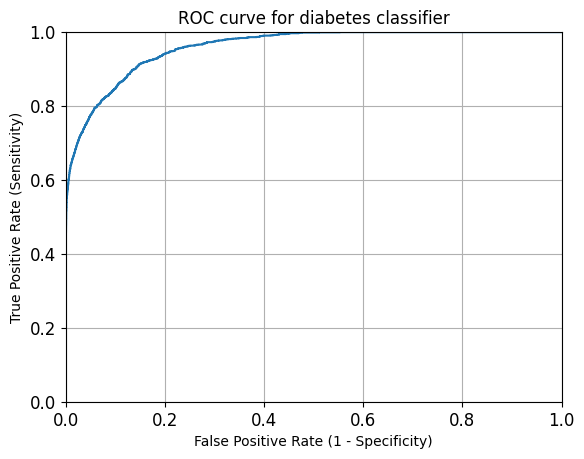

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title('ROC curve for diabetes classifier')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

#### Una función de apoyo para identificar la sensitividad de otra forma sin necesidad de cambiar los umbrales como en los pasos anteriores

In [31]:
def evaluate_threshold(threshold):
    print(f'La sensitividad para el threshold de {threshold} es', tpr[thresholds > threshold][-1])
evaluate_threshold(0.1)

La sensitividad para el threshold de 0.1 es 0.8608490566037735


#### El área bajo la curva, se espera que el valor obtenido sea mayor 0.7 para que sea aceptable

In [32]:
print(f'El valor del área bajo la curva con el umbral de clasificación de 0.5 es {metrics.roc_auc_score(y_test, y_pred_prob)}')
print(f'El valor del área bajo la curva con el umbral de clasificación de 0.1 es {metrics.roc_auc_score(y_test, y_pred_class)}')

El valor del área bajo la curva con el umbral de clasificación de 0.5 es 0.9593716574375176
El valor del área bajo la curva con el umbral de clasificación de 0.1 es 0.8772991718515618


### Deep learning

#### Se define el modelo y se trabaja con la función de activación sigmoid

#### Optimizador SGD

In [71]:
n_features = X.shape[1]
model_sgd_1 = Sequential()
model_sgd_1.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_sgd_1.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model_sgd_1.add(Dense(1, activation='sigmoid'))
sgd = SGD(learning_rate=0.001, momentum=0.8)
model_sgd_1.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/sgd_1/model_dense_{epoch:03d}.keras', monitor='val_loss', save_best_only=True)
epochs = 50
history = model_sgd_1.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_split=0.3, callbacks=[es, mc])

Epoch 1/50


C:\Users\PE11942\.virtualenvs\Environment-vge5gXGS\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9000 - loss: 1.2295 - val_accuracy: 0.9198 - val_loss: 0.2725
Epoch 2/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9222 - loss: 0.2686 - val_accuracy: 0.9210 - val_loss: 0.2657
Epoch 3/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9212 - loss: 0.2640 - val_accuracy: 0.9190 - val_loss: 0.2686
Epoch 4/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9199 - loss: 0.2640 - val_accuracy: 0.9215 - val_loss: 0.2644
Epoch 5/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9201 - loss: 0.2640 - val_accuracy: 0.9211 - val_loss: 0.2545
Epoch 6/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9195 - loss: 0.2586 - val_accuracy: 0.9220 - val_loss: 0.2521
Epoch 7/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9239 - loss: 0.2500 - val_accuracy: 0.9216 - val_loss: 0.2514
Epoch 8/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9231 - loss: 0.2453 - val_accurac

#### Plot de pérdida y exactitud en validación y entrenamiento

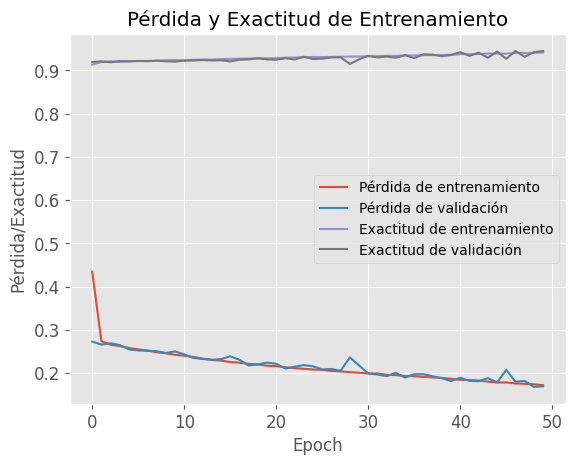

In [72]:
fig,ax = plt.subplots()
plt.style.use('ggplot')

epoch_values = list(range(len(history.history['loss'])))
ax.plot(epoch_values, history.history['loss'], label='Pérdida de entrenamiento')
ax.plot(epoch_values, history.history['val_loss'], label='Pérdida de validación')
ax.plot(epoch_values, history.history['accuracy'], label='Exactitud de entrenamiento')
ax.plot(epoch_values, history.history['val_accuracy'], label='Exactitud de validación')

ax.set_title('Pérdida y Exactitud de Entrenamiento')
ax.set_xlabel('Epoch')
ax.set_ylabel('Pérdida/Exactitud')
ax.legend()
plt.show()

#### Análisis de matriz de confusión con el umbral de clasificación en 0.5

In [73]:
loss, acc = model_sgd_1.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {acc:.3f}')

y_pred_prob = model_sgd_1.predict(X_test)[:, 0]
y_pred = binarize([y_pred_prob], threshold=0.5)[0]
result = metrics.confusion_matrix(y_test, y_pred)
print(f'La matriz de confusión con un umbral de 0.5 es la siguiente: \n {result}')
print(f'La sensitividad obtenida es de {metrics.recall_score(y_test, y_pred)}')

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9483 - loss: 0.1670
Test Accuracy: 0.946
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
La matriz de confusión con un umbral de 0.5 es la siguiente: 
 [[17406   128]
 [  910   786]]
La sensitividad obtenida es de 0.4634433962264151


#### Visualización de agrupamiento de valores predichos y modificación de la matriz de confusión mediante el reajuste del umbral de clasificación en 0.1

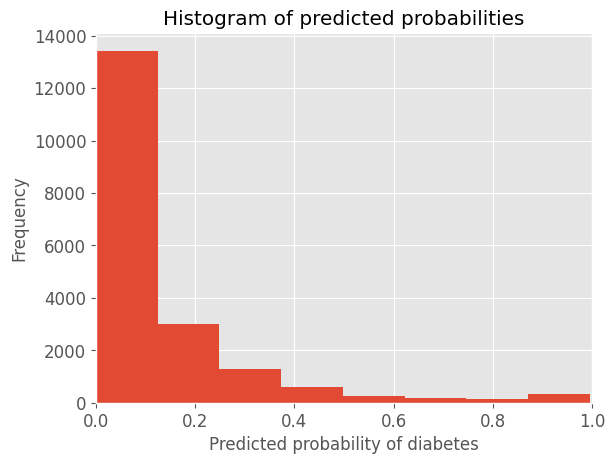

La matriz de confusión con un umbral de 0.1 es la siguiente: 
 [[12337  5197]
 [   87  1609]]
La nueva sensitividad obtenida es de 0.9487028301886793


In [74]:
fig, ax = plt.subplots()
ax.hist(y_pred_prob, bins=8)
ax.set_xlim(0, 1)
ax.set_title('Histogram of predicted probabilities')
ax.set_xlabel('Predicted probability of diabetes')
ax.set_ylabel('Frequency')
plt.show()

y_pred_adjusted = binarize([y_pred_prob], threshold=0.1)[0]
result = metrics.confusion_matrix(y_test, y_pred_adjusted)
print(f'La matriz de confusión con un umbral de 0.1 es la siguiente: \n {result}')
print(f'La nueva sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_adjusted)}')

#### Parte 2 ----------------
#### Trasteando mediante la agregación de capas Dropout

In [77]:
n_features = X.shape[1]
model_sgd_2 = Sequential()
model_sgd_2.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_sgd_2.add(Dropout(0.4))
model_sgd_2.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model_sgd_2.add(Dropout(0.4))
model_sgd_2.add(Dense(1, activation='sigmoid'))
sgd = SGD(learning_rate=0.001, momentum=0.8)
model_sgd_2.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/sgd_2/model_dense_{epoch:03d}.keras', monitor='val_loss', save_best_only=True)
epochs = 50
history = model_sgd_2.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_split=0.3, callbacks=[es, mc])

C:\Users\PE11942\.virtualenvs\Environment-vge5gXGS\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8915 - loss: 1.5141 - val_accuracy: 0.9112 - val_loss: 0.3155
Epoch 2/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9120 - loss: 0.3302 - val_accuracy: 0.9112 - val_loss: 0.3004
Epoch 3/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9121 - loss: 0.3021 - val_accuracy: 0.9112 - val_loss: 0.2752
Epoch 4/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9123 - loss: 0.2879 - val_accuracy: 0.9112 - val_loss: 0.2721
Epoch 5/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9108 - loss: 0.2859 - val_accuracy: 0.9112 - val_loss: 0.2722
Epoch 6/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9115 - loss: 0.2820 - val_accuracy: 0.9112 - val_loss: 0.2717
Epoch 7/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9122 - loss: 0.2810 - val_accuracy: 0.9112 - val_loss: 0.2756
Epoch 8/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9117 - loss: 0.2815 - 

#### Plot de pérdida y exactitud en validación y entrenamiento

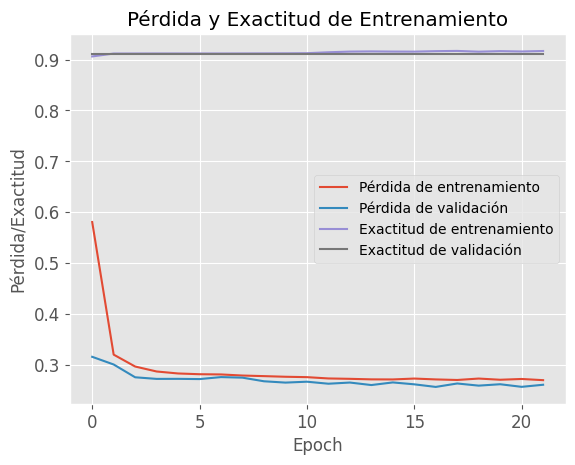

In [78]:
fig,ax = plt.subplots()
plt.style.use('ggplot')

epoch_values = list(range(len(history.history['loss'])))
ax.plot(epoch_values, history.history['loss'], label='Pérdida de entrenamiento')
ax.plot(epoch_values, history.history['val_loss'], label='Pérdida de validación')
ax.plot(epoch_values, history.history['accuracy'], label='Exactitud de entrenamiento')
ax.plot(epoch_values, history.history['val_accuracy'], label='Exactitud de validación')

ax.set_title('Pérdida y Exactitud de Entrenamiento')
ax.set_xlabel('Epoch')
ax.set_ylabel('Pérdida/Exactitud')
ax.legend()
plt.show()

#### Análisis de matriz de confusión con el umbral de clasificación en 0.5

In [79]:
loss, acc = model_sgd_2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {acc:.3f}')

y_pred_prob = model_sgd_2.predict(X_test)[:, 0]
y_pred = binarize([y_pred_prob], threshold=0.5)[0]
result = metrics.confusion_matrix(y_test, y_pred)
print(f'La matriz de confusión con un umbral de 0.5 es la siguiente: \n {result}')
print(f'La sensitividad obtenida es de {metrics.recall_score(y_test, y_pred)}')

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9152 - loss: 0.2523
Test Accuracy: 0.912
601/601 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
La matriz de confusión con un umbral de 0.5 es la siguiente: 
 [[17534     0]
 [ 1696     0]]
La sensitividad obtenida es de 0.0


#### Visualización de agrupamiento de valores predichos y modificación de la matriz de confusión mediante el reajuste del umbral de clasificación en 0.1

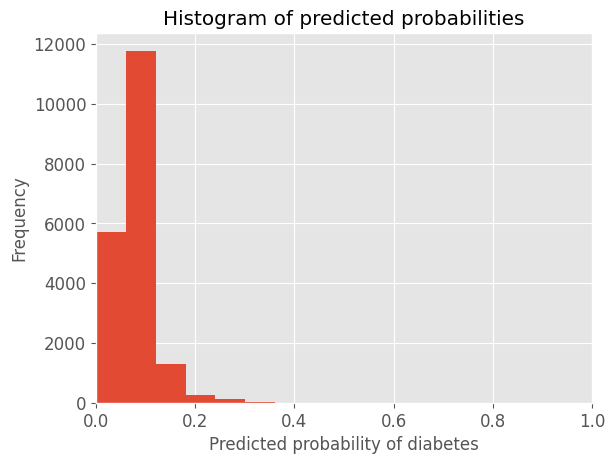

La matriz de confusión con un umbral de 0.1 es la siguiente: 
 [[9381 8153]
 [ 237 1459]]
La nueva sensitividad obtenida es de 0.8602594339622641


In [80]:
fig, ax = plt.subplots()
ax.hist(y_pred_prob, bins=8)
ax.set_xlim(0, 1)
ax.set_title('Histogram of predicted probabilities')
ax.set_xlabel('Predicted probability of diabetes')
ax.set_ylabel('Frequency')
plt.show()

y_pred_adjusted = binarize([y_pred_prob], threshold=0.1)[0]
result = metrics.confusion_matrix(y_test, y_pred_adjusted)
print(f'La matriz de confusión con un umbral de 0.1 es la siguiente: \n {result}')
print(f'La nueva sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_adjusted)}')

#### Optimizador ADAM

In [11]:
n_features = X.shape[1]
model_adam_1 = Sequential()
model_adam_1.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_adam_1.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model_adam_1.add(Dense(1, activation='sigmoid'))
model_adam_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/adam_1/model_dense_{epoch:03d}.keras', monitor='val_loss', save_best_only=True)

epochs = 50
history = model_adam_1.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_split=0.3, callbacks=[es, mc])

Epoch 1/50


C:\Users\PE11942\.virtualenvs\Environment-vge5gXGS\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8920 - loss: 0.6962 - val_accuracy: 0.9216 - val_loss: 0.2597
Epoch 2/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9230 - loss: 0.2517 - val_accuracy: 0.9205 - val_loss: 0.2411
Epoch 3/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9256 - loss: 0.2305 - val_accuracy: 0.9278 - val_loss: 0.2052
Epoch 4/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9330 - loss: 0.1987 - val_accuracy: 0.9288 - val_loss: 0.2027
Epoch 5/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9371 - loss: 0.1836 - val_accuracy: 0.9404 - val_loss: 0.1744
Epoch 6/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9425 - loss: 0.1680 - val_accuracy: 0.9400 - val_loss: 0.1598
Epoch 7/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9430 - loss: 0.1597 - val_accuracy: 0.9458 - val_loss: 0.1459
Epoch 8/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9487 - loss: 0.1455 - val_accurac

#### Plot de pérdida y exactitud en validación y entrenamiento

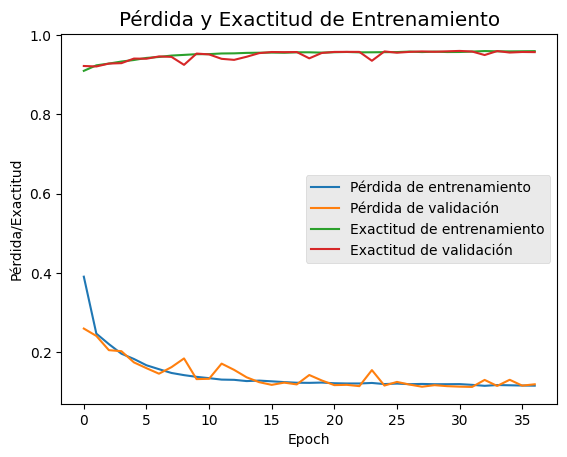

In [12]:
fig,ax = plt.subplots()
plt.style.use('ggplot')

epoch_values = list(range(len(history.history['loss'])))
ax.plot(epoch_values, history.history['loss'], label='Pérdida de entrenamiento')
ax.plot(epoch_values, history.history['val_loss'], label='Pérdida de validación')
ax.plot(epoch_values, history.history['accuracy'], label='Exactitud de entrenamiento')
ax.plot(epoch_values, history.history['val_accuracy'], label='Exactitud de validación')

ax.set_title('Pérdida y Exactitud de Entrenamiento')
ax.set_xlabel('Epoch')
ax.set_ylabel('Pérdida/Exactitud')
ax.legend()
plt.show()

#### Análisis de matriz de confusión con el umbral de clasificación en 0.5

In [13]:
loss, acc = model_adam_1.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {acc:.3f}')

y_pred_prob = model_adam_1.predict(X_test)[:, 0]
y_pred = binarize([y_pred_prob], threshold=0.5)[0]
result = metrics.confusion_matrix(y_test, y_pred)
print(f'La matriz de confusión con un umbral de 0.5 es la siguiente: \n {result}')
print(f'La sensitividad obtenida es de {metrics.recall_score(y_test, y_pred)}')

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9617 - loss: 0.1101
Test Accuracy: 0.959
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
La matriz de confusión con un umbral de 0.5 es la siguiente: 
 [[17500    34]
 [  762   934]]
La sensitividad obtenida es de 0.5507075471698113


#### Visualización de agrupamiento de valores predichos y modificación de la matriz de confusión mediante el reajuste del umbral de clasificación en 0.1

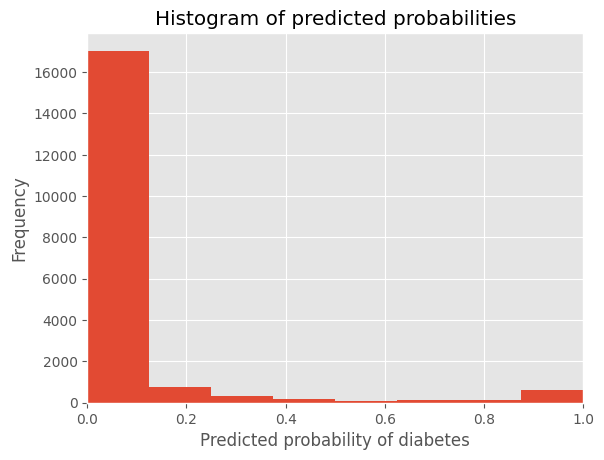

La matriz de confusión con un umbral de 0.1 es la siguiente: 
 [[16436  1098]
 [  322  1374]]
La nueva sensitividad obtenida es de 0.8101415094339622


In [14]:
fig, ax = plt.subplots()
ax.hist(y_pred_prob, bins=8)
ax.set_xlim(0, 1)
ax.set_title('Histogram of predicted probabilities')
ax.set_xlabel('Predicted probability of diabetes')
ax.set_ylabel('Frequency')
plt.show()

y_pred_adjusted = binarize([y_pred_prob], threshold=0.1)[0]
result = metrics.confusion_matrix(y_test, y_pred_adjusted)
print(f'La matriz de confusión con un umbral de 0.1 es la siguiente: \n {result}')
print(f'La nueva sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_adjusted)}')

#### Trasteando mediante la agregación de capas Dropout

In [16]:
n_features = X.shape[1]
model_adam_2 = Sequential()
model_adam_2.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_adam_2.add(Dropout(0.4))
model_adam_2.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model_adam_2.add(Dropout(0.4))
model_adam_2.add(Dense(1, activation='sigmoid'))
model_adam_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/adam_2/model_dense_{epoch:03d}.keras', monitor='val_loss', save_best_only=True)
epochs = 50
history = model_adam_2.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_split=0.3, callbacks=[es, mc])

Epoch 1/50


C:\Users\PE11942\.virtualenvs\Environment-vge5gXGS\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8389 - loss: 3.7139 - val_accuracy: 0.9112 - val_loss: 0.3496
Epoch 2/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9101 - loss: 0.3474 - val_accuracy: 0.9112 - val_loss: 0.3003
Epoch 3/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9109 - loss: 0.3066 - val_accuracy: 0.9112 - val_loss: 0.2935
Epoch 4/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9114 - loss: 0.2941 - val_accuracy: 0.9112 - val_loss: 0.2934
Epoch 5/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9133 - loss: 0.2814 - val_accuracy: 0.9112 - val_loss: 0.2797
Epoch 6/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9140 - loss: 0.2729 - val_accuracy: 0.9112 - val_loss: 0.2688
Epoch 7/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9164 - loss: 0.2605 - val_accuracy: 0.9112 - val_loss: 0.2556
Epoch 8/50
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9197 - loss: 0.2464 - val_accurac

#### Plot de pérdida y exactitud en validación y entrenamiento

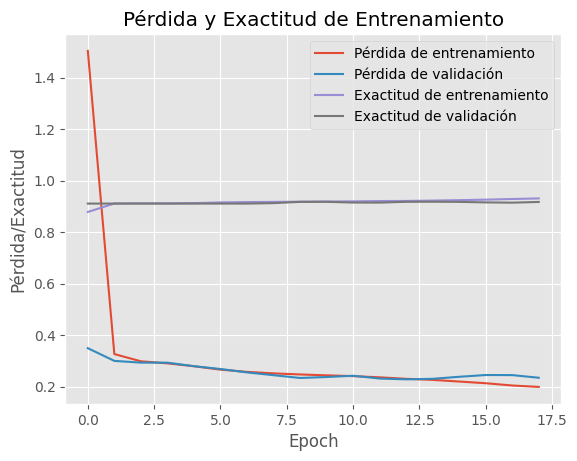

In [17]:
fig,ax = plt.subplots()
plt.style.use('ggplot')

epoch_values = list(range(len(history.history['loss'])))
ax.plot(epoch_values, history.history['loss'], label='Pérdida de entrenamiento')
ax.plot(epoch_values, history.history['val_loss'], label='Pérdida de validación')
ax.plot(epoch_values, history.history['accuracy'], label='Exactitud de entrenamiento')
ax.plot(epoch_values, history.history['val_accuracy'], label='Exactitud de validación')

ax.set_title('Pérdida y Exactitud de Entrenamiento')
ax.set_xlabel('Epoch')
ax.set_ylabel('Pérdida/Exactitud')
ax.legend()
plt.show()

#### Análisis de matriz de confusión con el umbral de clasificación en 0.5

In [18]:
loss, acc = model_adam_2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {acc:.3f}')

y_pred_prob = model_adam_2.predict(X_test)[:, 0]
y_pred = binarize([y_pred_prob], threshold=0.5)[0]
result = metrics.confusion_matrix(y_test, y_pred)
print(f'La matriz de confusión con un umbral de 0.5 es la siguiente: \n {result}')
print(f'La sensitividad obtenida es de {metrics.recall_score(y_test, y_pred)}')

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9228 - loss: 0.2221
Test Accuracy: 0.920
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
La matriz de confusión con un umbral de 0.5 es la siguiente: 
 [[17534     0]
 [ 1541   155]]
La sensitividad obtenida es de 0.09139150943396226


#### Visualización de agrupamiento de valores predichos y modificación de la matriz de confusión mediante el reajuste del umbral de clasificación en 0.1

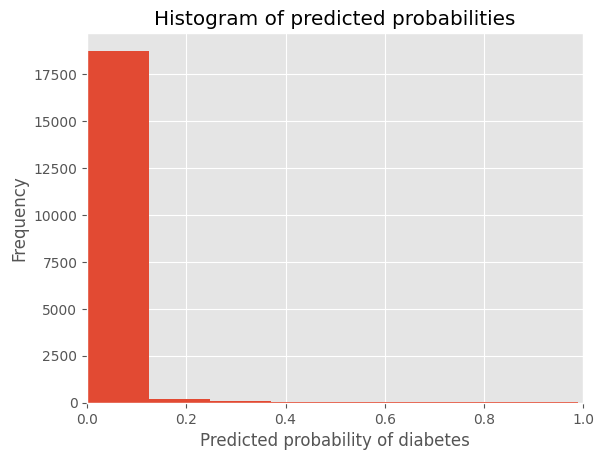

La matriz de confusión con un umbral de 0.1 es la siguiente: 
 [[17469    65]
 [ 1105   591]]
La nueva sensitividad obtenida es de 0.34846698113207547


In [19]:
fig, ax = plt.subplots()
ax.hist(y_pred_prob, bins=8)
ax.set_xlim(0, 1)
ax.set_title('Histogram of predicted probabilities')
ax.set_xlabel('Predicted probability of diabetes')
ax.set_ylabel('Frequency')
plt.show()

y_pred_adjusted = binarize([y_pred_prob], threshold=0.1)[0]
result = metrics.confusion_matrix(y_test, y_pred_adjusted)
print(f'La matriz de confusión con un umbral de 0.1 es la siguiente: \n {result}')
print(f'La nueva sensitividad obtenida es de {metrics.recall_score(y_test, y_pred_adjusted)}')

### Síntesis de resultados y conclusiones

Mediante ML & sklearn:
    
    > Para KNN: Se usó GridSearchCV con cross validation de 10, buscando los párametros K y weight.    
        Umbral por defecto: La sensitividad obtenida es de 0.5135613207547169
        Matriz de confusión:
             [[17439    95]
             [  825   871]]

        Umbral ajustado (0.1): La nueva sensitividad obtenida es de 0.8567216981132075
        Matriz de confusión:
             [[14938  2596]
             [  243  1453]]
             
    > Para regresión logística: Se usó RandomizedSearchCV con cross validation de 10, buscando los párametros iter_range, solver, penalty
        Umbral por defecto: La sensitividad obtenida es de 0.5135613207547169
        Matriz de confusión:
             [[17439    95]
             [  825   871]]

        Umbral ajustado (0.1): La nueva sensitividad obtenida es de 0.8567216981132075
        Matriz de confusión:
             [[14938  2596]
             [  243  1453]]
Mediante DL & Keras sequential: -> 50 epochs para cada uno de los siguientes casos.
    
    > Con el optimizador SGD: Se uso la función de activación 'sigmoid', y los parámetros learning rate y momentum con valores de 0.001 y 0.8 respectivamente.
        Además, se uso binary_crossentropy como pérdida y la métrica fue la precisión. Por otro lado, se definió un early stopping de 5 en base a la pérdida en la validación.
        Finalmente, se usaron 3 capas Dense.
        
        Umbral por defecto: La sensitividad obtenida es de 0.4634433962264151
        Matriz de confusión:
             [[17406   128]
             [  910   786]]

        Umbral ajustado (0.1): La nueva sensitividad obtenida es de 0.9487028301886793
        Matriz de confusión:
             [[12337  5197]
             [   87  1609]]
    
    > Con el optimizador SGD (usando los mismos hiperpárametros anteriores) más la adición de dos capas de Dropout de 04.4 cada uno.
        
        Umbral por defecto: La sensitividad obtenida es de 0.0
        Matriz de confusión:
             [[17534     0]
             [ 1696     0]]

        Umbral ajustado (0.1): La nueva sensitividad obtenida es de 0.8602594339622641
        Matriz de confusión:
             [[9381 8153]
             [ 237 1459]]
                
    > Con el optimizador ADAM: Se uso la función de activación 'sigmoid', y los parámetros learning rate y momentum con valores de 0.001 y 0.8 respectivamente.
        Además, se uso binary_crossentropy como pérdida y la métrica fue la precisión. Por otro lado, se definió un early stopping de 5 en base a la pérdida en la validación.
        Finalmente, se usaron 3 capas Dense.
        
        Umbral por defecto: La sensitividad obtenida es de 0.5507075471698113
        Matriz de confusión:
             [[17500    34]
             [  762   934]]

        Umbral ajustado (0.1): La nueva sensitividad obtenida es de 0.8101415094339622
        Matriz de confusión:
             [[16436  1098]
             [  322  1374]]
    
    > Con el optimizador ADAM (usando los mismos hiperpárametros anteriores) más la adición de dos capas de Dropout de 04.4 cada uno.
        
        Umbral por defecto: La sensitividad obtenida es de 0.09139150943396226
        Matriz de confusión:
             [[17534     0]
             [ 1541   155]]

        Umbral ajustado (0.1): La nueva sensitividad obtenida es de 0.34846698113207547
        Matriz de confusión:
             [[17469    65]
             [ 1105   591]]

Dado los resultados anteriores, puedo concluir que en base al tipo de solución (medicina), donde los falsos positivos son más aceptables que los falsos negativos (pacientes catalogados como sanos que realmente requieren atención médica), la sensitividad debe ser más próxima a 1. Por lo que, en base a los modelos entrenados se obtuvo un mayor valor de sensitividad (0.948) con Deep learning y sequential de Keras mediante el optimizador SGD con el umbral ajustado 0.1. 

Traduciéndolo como un total de 87 pacientes de una muestra de 19230 pacientes quienes no fueron clasificados correctamente para una próxima cita con los especialistas de salud.

* Nótese que para el análisis se ha usado 0.1 como umbral ajustado de cada modelo entrenado.